**Problem statement:** 

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Steps Followed:**

1.   Data Loading and Understanding
2.   Dataset Creation
3.   Dataset Visualization
4.   Model 1 Building , Training , Evaluation and Findings -- CNN Model with Dropout layer
5.   Model 2 Building , Training , Evaluation and Findings -- CNN Model with Augmented data and Dropout layer
6.   Model 3 Building , training , Evaluation and Findings - CNN Model with Augmentor to rectify imbalance class data

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [56]:
import pathlib
import tensorflow as tf
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from __future__ import print_function
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from tensorflow.keras.regularizers import l2

In [57]:
print("Tensorflow Version:",tf. __version__)
print("Numpy Version:",np. __version__) 
print("pandas Version:",pd. __version__) 
print("Matplotlib Version:",mat. __version__) 

Tensorflow Version: 2.9.2
Numpy Version: 1.21.6
pandas Version: 1.3.5
Matplotlib Version: 3.2.2


In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  validation_split=0.2,
  color_mode='rgb',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  validation_split=0.2,
  color_mode='rgb',
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

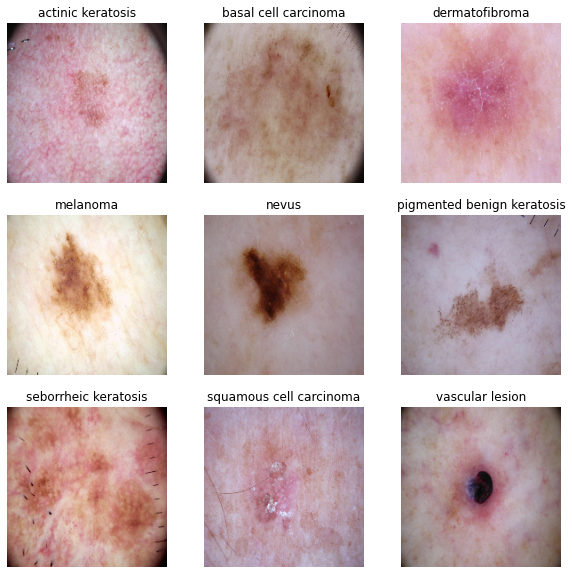

In [14]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

fig = plt.figure(figsize=(10, 10))

classes = range(len(class_names))
for images, labels in val_ds.take(1):
    missing = []
    for i in classes:
        ax = fig.add_subplot(3, 3, 1 + i)
        x = np.where(labels[:]==i)[0]
        if len(x) > 0:
            idx = np.where(labels[:]==i)[0][0]
            im = images[idx].numpy().astype("uint8")
            plt.imshow(im)
            plt.title(class_names[labels[idx]])
            plt.axis("off")
        else:
            missing.append(i) # Appending list for missing classes
    if len(missing) > 0:
        classes = missing
        continue
    else:
        break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]


**Model 1: CNN Model with Dropout layer**


In [17]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# Adding Conv layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 180, 180, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 90, 90, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 90, 90, 64)       18496     
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 45, 45, 64)       0         
 pper)                                                  

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
### Todo, choose an appropirate optimiser and loss function
from tensorflow.keras.optimizers import Adam
optimizer_1 = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_function_1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer_1,
              loss=loss_function_1,
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 180, 180, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 90, 90, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 90, 90, 64)       18496     
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 45, 45, 64)       0         
 pper)                                                  

In [20]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,callbacks=[learning_rate_reduction]
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 272s 434ms/step - loss: 2.0130 - accuracy: 0.2489 - val_loss: 1.9337 - val_accuracy: 0.3266 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 3s 46ms/step - loss: 1.7968 - accuracy: 0.3438 - val_loss: 1.5431 - val_accuracy: 0.4676 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.5892 - accuracy: 0.4386 - val_loss: 1.5194 - val_accuracy: 0.4832 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5065 - accuracy: 0.4688 - val_loss: 1.4371 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4259 - accuracy: 0.5084 - val_loss: 1.5400 - val_accuracy: 0.4787 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4344 - accuracy: 0.4794 - val_loss: 1.4225 - val_accuracy: 0.5011 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 3s 48ms/step - loss: 1.3638 - ac

**Visualizing Training Results**

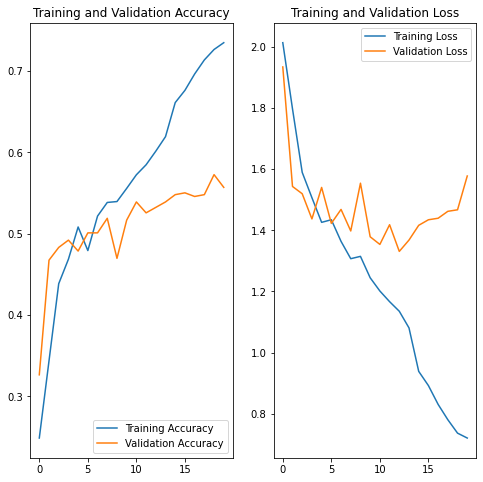

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 20ms/step - loss: 1.5774 - accuracy: 0.5570
Accuracy:  0.7924107313156128
Validation Accuracy:  0.5570470094680786
Loss:  0.5902606248855591
Validation Loss 1.5773696899414062


**Model 1: Insights:**


1. With the increase in the number of epochs training accuracy increased
2. Final accuracy for training dataset is 79.24%
3. Validation accuracy increases for some ecpochs and then becomes almost constant 
4. Final accuracy for validation dataset is 55.7%
5. Training loss decreses with increase in epochs but validation loss decreases first with increse in epochs and then become almost constant.
6. We can see that validation dataset accuracy is too low than training dataset accuracy, the model seems to be overfitting
7. Overfitting happened since we have less number of training images and model has learnt from noise or unwanted details around the training data.
8. We will use Data Augmentation to overcome overfitting. Data augmentation will add additional training data by applying transformation on existing data. This will expose the model to more aspects of the data.


**Model - 2**

In [25]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
with tf.device('/CPU:0'):
    data_augmentation = keras.Sequential(
      [
       # Random flip of image of horizontal axis
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
       # Random rotation of image
        layers.experimental.preprocessing.RandomRotation(0.2),
       # Random zoom of image
        layers.experimental.preprocessing.RandomZoom(0.2),
      ]
    )

<ipython-input-26-5f7a25dd11f6>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(3, 3, 1 + i)


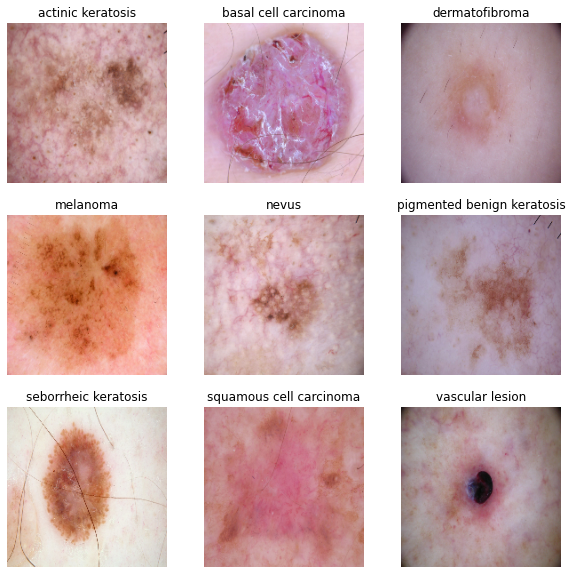

In [26]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
fig = plt.figure(figsize=(10, 10))

classes = range(len(class_names))
for images, labels in val_ds.take(2):
    missing = []
    for i in classes:
        ax = fig.add_subplot(3, 3, 1 + i)
        x = np.where(labels[:]==i)[0]
        if len(x) > 0:
            idx = np.where(labels[:]==i)[0][0]
            augmented_images = data_augmentation(images)
            im = images[idx].numpy().astype("uint8")
            plt.imshow(im)
            plt.title(class_names[labels[idx]])
            plt.axis("off")
        else:
            missing.append(i) # Appending list for missing classes
    if len(missing) > 0:
        classes = missing
        continue
    else:
        break

### Todo:
### Create the model, compile and train the model


In [27]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# Adding Conv layers
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_13 (ModuleWr  (None, 180, 180, 16)     448       
 apper)                                                          
                                                                 
 module_wrapper_14 (ModuleWr  (None, 90, 90, 16)       0         
 apper)                                                          
                                                                 
 module_wrapper_15 (ModuleWr  (None, 90, 90, 32)       4640      
 apper)                                                          
                                                                 
 module_wrapper_16 (ModuleWr  (None, 45, 45, 32)       0         
 apper)                                               

### Compiling the model

In [28]:
## Your code goes here
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

### Training the model

In [29]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learning_rate_reduction]
)

Epoch 1/20
56/56 [==============================] - 3s 32ms/step - loss: 2.0341 - accuracy: 0.2137 - val_loss: 1.9351 - val_accuracy: 0.2662 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 1.8589 - accuracy: 0.2980 - val_loss: 1.7763 - val_accuracy: 0.3714 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.7369 - accuracy: 0.3594 - val_loss: 1.6635 - val_accuracy: 0.4094 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6835 - accuracy: 0.3856 - val_loss: 1.6714 - val_accuracy: 0.3915 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5581 - accuracy: 0.4475 - val_loss: 1.4898 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4648 - accuracy: 0.4816 - val_loss: 1.4331 - val_accuracy: 0.5056 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 1s 27ms/step - loss: 1.4

### Visualizing the results

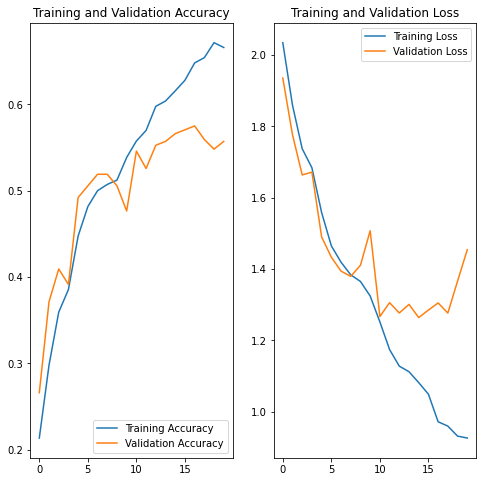

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [31]:
## Your code goes here.

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 12ms/step - loss: 1.4538 - accuracy: 0.5570
Accuracy:  0.6902901530265808
Validation Accuracy:  0.5570470094680786
Loss:  0.8508944511413574
Validation Loss 1.4538241624832153


**Model-2 Insights:**

- With the increase in number of epochs, both training and validation accuracies got increased
- Training loss decreses with increase in epochs but validation loss decreases first with increse in epochs and then there is a slight increase
- Training Accuracy is 69.02% and validation Accuracy 55.7%
- Training and validation accuracy are almost equal hence overfitting problem resolved
- Current model is underfitting since the model accuracy has been decreased from 79% to 69%


In [32]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026650.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026848.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026468.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026765.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026212.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026040.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detecti

In [33]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [34]:
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

**Insights:**

- 'seborrheic keratosis' class has least number of samples.
- 'pigmented benign keratosis' and 'melanoma' class dominate the data in terms of proportionate number of samples.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB8FF87B3D0>: 100%|██████████| 500/500 [00:18<00:00, 27.07 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB8FF7DEB80>: 100%|██████████| 500/500 [00:18<00:00, 27.29 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB8773A9EB0>: 100%|██████████| 500/500 [00:19<00:00, 26.10 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB95AF77B20>: 100%|██████████| 500/500 [01:31<00:00,  5.49 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FB8F3564DF0>: 100%|██████████| 500/500 [01:18<00:00,  6.38 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB8F3512A30>: 100%|██████████| 500/500 [00:18<00:00, 27.43 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB877171F70>: 100%|██████████| 500/500 [00:41<00:00, 11.94 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB877439100>: 100%|██████████| 500/500 [00:18<00:00, 27.74 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB87712C370>: 100%|██████████| 500/500 [00:18<00:00, 27.54 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [41]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028190.jpg_ca1dd8e7-db0e-4348-a854-72992cf19ff5.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026625.jpg_0d9b22aa-c990-4e95-8282-1545b5a0b71b.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033151.jpg_d2404d63-be78-4d0e-8d97-1949f754ee61.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027829.jpg_3c8482d5-0313-4e65-8d8f-828024f9c2cc.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_Asmt/Skin cance

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [43]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [45]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [46]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [47]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [49]:
## your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# Adding Conv layer
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_28 (ModuleWr  (None, 180, 180, 16)     448       
 apper)                                                          
                                                                 
 module_wrapper_29 (ModuleWr  (None, 90, 90, 16)       0         
 apper)                                                          
                                                                 
 module_wrapper_30 (ModuleWr  (None, 90, 90, 32)       4640      
 apper)                                                          
                                                                 
 module_wrapper_31 (ModuleWr  (None, 45, 45, 32)       0         
 apper)                                               

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [50]:
## your code goes here
### choosing an appropirate optimiser and loss function
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [51]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learning_rate_reduction]
)

Epoch 1/50
169/169 [==============================] - 34s 188ms/step - loss: 1.8782 - accuracy: 0.2761 - val_loss: 1.6204 - val_accuracy: 0.3734 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 31s 179ms/step - loss: 1.5311 - accuracy: 0.4078 - val_loss: 1.4405 - val_accuracy: 0.4566 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 31s 180ms/step - loss: 1.3812 - accuracy: 0.4731 - val_loss: 1.3376 - val_accuracy: 0.4766 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 33s 187ms/step - loss: 1.2722 - accuracy: 0.5059 - val_loss: 1.2948 - val_accuracy: 0.5108 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 31s 181ms/step - loss: 1.1186 - accuracy: 0.5736 - val_loss: 1.1887 - val_accuracy: 0.5464 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 31s 179ms/step - loss: 0.9663 - accuracy: 0.6333 - val_loss: 1.0989 - val_accuracy: 0.5880 - lr: 0.0010
Epoch 7/50
169/169 [==============================] 

#### **Todo:**  Visualize the model results

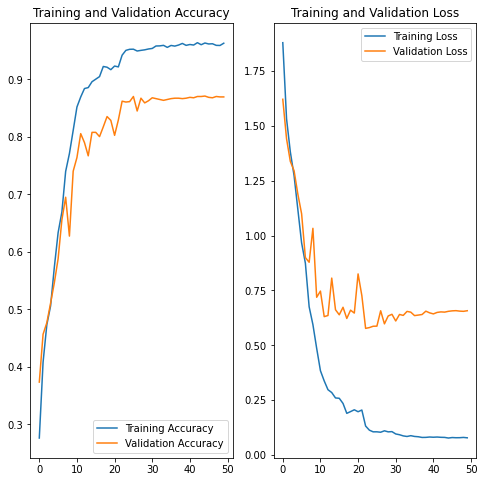

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 6s 117ms/step - loss: 0.6575 - accuracy: 0.8693
Accuracy:  0.9642062187194824
Validation Accuracy:  0.8693392872810364
Loss:  0.07351130247116089
Validation Loss 0.6574521064758301


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Model-3 Insights:**

- Training accuracy is 96.42% and validation accuracy is 86.93 %
- After using Augmentor and treating imbalance of all classes, there is a significance improvement in the training and validation accuracy
- More epochs can be added to increase the accuracy Further
- Final model has no overfitting or underfitting
- By increase in number of epochs, training and validation loss has been decreased

